In [9]:
import hoomd
import os
import gsd.hoomd
import math
import freud

import io
import os
import warnings

import fresnel
import IPython
import numpy
import packaging.version
import PIL

import matplotlib
import matplotlib_inline
matplotlib.style.use("ggplot")

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [2]:
# This is not intended as a full tutorial on fresnel - see the fresnel user
# documentation (https://fresnel.readthedocs.io/) if you would like to learn more.

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")


def render(snapshot):
    if (
        "version" not in dir(fresnel)
        or packaging.version.parse(fresnel.version.version) < FRESNEL_MIN_VERSION
        or packaging.version.parse(fresnel.version.version) >= FRESNEL_MAX_VERSION
    ):
       warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )
    L = snapshot.configuration.box[0]
    vertices = [
        (-0.5, 0, 0),
        (0.5, 0, 0),
        (0, -0.5, 0),
        (0, 0.5, 0),
        (0, 0, -0.5),
        (0, 0, 0.5),
    ]
    poly_info = fresnel.util.convex_polyhedron_from_vertices(vertices)

    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.ConvexPolyhedron(
        scene, poly_info, N=snapshot.particles.N
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([0.01, 0.74, 0.26]), roughness=0.5
    )
    geometry.position[:] = snapshot.particles.position[:]
    geometry.orientation[:] = snapshot.particles.orientation[:]
    geometry.outline_width = 0.01
    fresnel.geometry.Box(scene, snapshot.configuration.box, box_radius=0.02)
    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(L * 2, L, L * 2), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.4 + 1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    samples = 2000
    if "CI" in os.environ:
        samples = 100
    return IPython.display.Image(tracer.sample(scene, samples=samples)._repr_png_())

In [3]:
# This is not intended as a full tutorial on fresnel - see the fresnel user
# documentation (https://fresnel.readthedocs.io/) if you would like to learn more.

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")


def render_helper(snapshot, particles=None, is_solid=None):
    if (
        "version" not in dir(fresnel)
        or packaging.version.parse(fresnel.version.version) < FRESNEL_MIN_VERSION
        or packaging.version.parse(fresnel.version.version) >= FRESNEL_MAX_VERSION
    ):
        warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )
    vertices = [
        (-0.5, 0, 0),
        (0.5, 0, 0),
        (0, -0.5, 0),
        (0, 0.5, 0),
        (0, 0, -0.5),
        (0, 0, 0.5),
    ]
    poly_info = fresnel.util.convex_polyhedron_from_vertices(vertices)
    N = snapshot.particles.N
    L = snapshot.configuration.box[0]
    if particles is not None:
        N = len(particles)
    if is_solid is not None:
        N = int(numpy.sum(is_solid))

    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.ConvexPolyhedron(scene, poly_info, N=N)
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([0.01, 0.74, 0.26]), roughness=0.5
    )
    if particles is None and is_solid is None:
        geometry.position[:] = snapshot.particles.position[:]
        geometry.orientation[:] = snapshot.particles.orientation[:]
    elif particles is not None:
        geometry.position[:] = snapshot.particles.position[particles, :]
        geometry.orientation[:] = snapshot.particles.orientation[particles, :]
    elif is_solid is not None:
        geometry.position[:] = snapshot.particles.position[
            numpy.ix_(is_solid, [0, 1, 2])
        ]
        geometry.orientation[:] = snapshot.particles.orientation[
            numpy.ix_(is_solid, [0, 1, 2, 3])
        ]

    geometry.outline_width = 0.01
    fresnel.geometry.Box(scene, snapshot.configuration.box, box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(L * 2, L, L * 2), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.4 + 1
    )
    scene.background_color = (1, 1, 1)
    samples = 2000
    if "CI" in os.environ:
        samples = 100
    return tracer.sample(scene, samples=samples)


def render_movie(frames, particles=None, is_solid=None):
    if is_solid is None:
        is_solid = [None] * len(frames)
    a = render_helper(frames[0], particles, is_solid[0])

    im0 = PIL.Image.fromarray(a[:, :, 0:3], mode="RGB").convert(
        "P", palette=PIL.Image.Palette.ADAPTIVE
    )
    ims = []
    for i, f in enumerate(frames[1:]):
        a = render_helper(f, particles, is_solid[i])
        im = PIL.Image.fromarray(a[:, :, 0:3], mode="RGB")
        im_p = im.quantize(palette=im0)
        ims.append(im_p)

    blank = numpy.ones(shape=(im.height, im.width, 3), dtype=numpy.uint8) * 255
    im = PIL.Image.fromarray(blank, mode="RGB")
    im_p = im.quantize(palette=im0)
    ims.append(im_p)

    f = io.BytesIO()
    im0.save(f, "gif", save_all=True, append_images=ims, duration=1000, loop=0)

    size = len(f.getbuffer()) / 1024
    if size > 3000:
        warnings.warn(f"Large GIF: {size} KiB")
    return IPython.display.display(IPython.display.Image(data=f.getvalue()))

In [4]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=12)
simulation.create_state_from_gsd(filename="/home/user/sticky_particles/snapshots/lattice.gsd")

render(simulation.state.get_snapshot())

KeyboardInterrupt: 

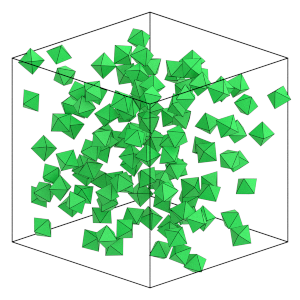

In [ ]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=12)
simulation.create_state_from_gsd(filename="/home/user/sticky_particles/snapshots/random.gsd")

render(simulation.state.get_snapshot())

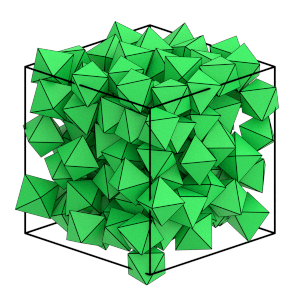

In [ ]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=12)
simulation.create_state_from_gsd(filename="/home/user/sticky_particles/snapshots/compressed.gsd")

render(simulation.state.get_snapshot())

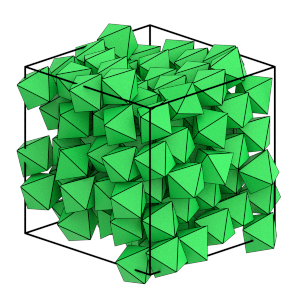

In [ ]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=12)
traj = gsd.hoomd.open("/home/user/sticky_particles/snapshots/trajectory.gsd")
#simulation.create_state_from_gsd(filename="/home/user/sticky_particles/snapshots/trajectory.gsd")

render(traj[-1])

205


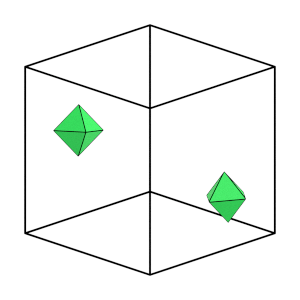

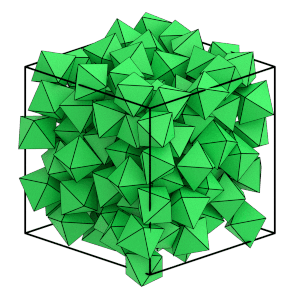

In [ ]:
traj = gsd.hoomd.open("/home/user/sticky_particles/snapshots/trajectory.gsd")
print(len(traj))

render_movie(traj[0:50:5], particles=[12, 18])
render_movie(traj[0::24])

In [5]:
traj = gsd.hoomd.open("/home/user/sticky_particles/snapshots/trajectory.gsd")
print(len(traj))

# The Freud library uses spherical harmonic wizardry to determine how "solid" things are
solid = freud.order.SolidLiquid(l=6, q_threshold=0.6, solid_threshold=5)
is_solid = []
for frame in traj:
    solid.compute(
        system=(frame.configuration.box, frame.particles.position),
        neighbors=dict(mode="nearest", num_neighbors=8),
    )
    is_solid.append(solid.num_connections > solid.solid_threshold)

205


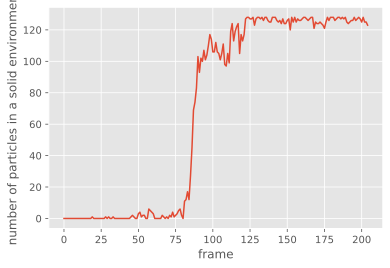

In [ ]:
import numpy as np

# As equilibrium is reached, the particles lock-in and become "solid-like"
fig = matplotlib.figure.Figure(figsize=(6, 4))
ax = fig.add_subplot()
num_solid = numpy.array([numpy.sum(a) for a in is_solid])
index = np.arange(0, len(traj))
ax.plot(num_solid)
#ax.scatter(index, num_solid)
ax.set_xlabel("frame")
ax.set_ylabel("number of particles in a solid environment")
fig

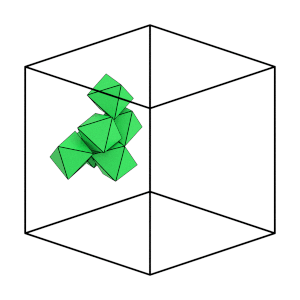

In [ ]:
start_frame = int(numpy.argmax(num_solid > 4))
end_frame = int(numpy.argmax(num_solid == numpy.max(num_solid)))
step = int((end_frame - start_frame) / 6)
render_movie(
    traj[start_frame:end_frame:step], is_solid=is_solid[start_frame:end_frame:step]
)

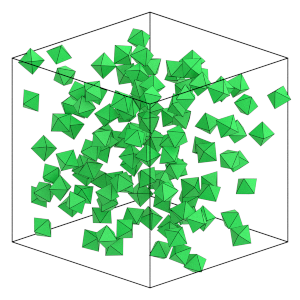

In [10]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=12)
simulation.create_state_from_gsd(filename="/home/user/sticky_particles/snapshots/random.gsd")

render(simulation.state.get_snapshot())

In [7]:
# This is not intended as a full tutorial on fresnel - see the fresnel user
# documentation (https://fresnel.readthedocs.io/) if you would like to learn more.

import warnings

import fresnel
import IPython
import packaging.version

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")


def render_spherical(snapshot):
    if (
        "version" not in dir(fresnel)
        or packaging.version.parse(fresnel.version.version) < FRESNEL_MIN_VERSION
        or packaging.version.parse(fresnel.version.version) >= FRESNEL_MAX_VERSION
    ):
        warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )
    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(
        scene, N=len(snapshot.particles.position), radius=0.5
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([252 / 255, 209 / 255, 1 / 255]), roughness=0.5
    )
    geometry.position[:] = snapshot.particles.position[:]
    geometry.outline_width = 0.04
    fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(L * 2, L, L * 2), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.4 + 1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    samples = 2000
    if "CI" in os.environ:
        samples = 100
    return IPython.display.Image(tracer.sample(scene, samples=samples)._repr_png_())

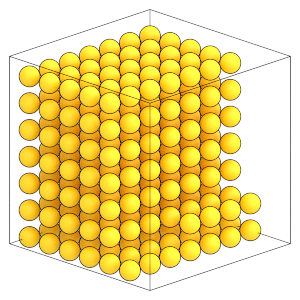

In [8]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=12)
simulation.create_state_from_gsd(filename="/home/user/sticky_particles/snapshots/lattice_2.gsd")

render_spherical(simulation.state.get_snapshot())

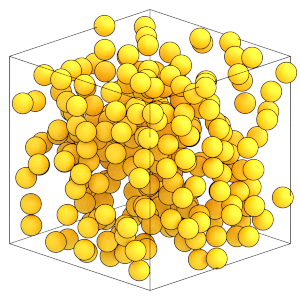

In [11]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=12)
simulation.create_state_from_gsd(filename="/home/user/sticky_particles/snapshots/randomized_2.gsd")

render_spherical(simulation.state.get_snapshot())

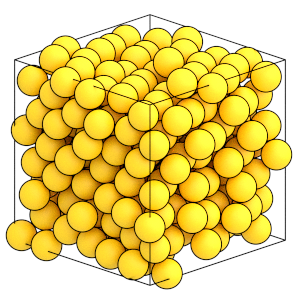

In [12]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=12)
simulation.create_state_from_gsd(filename="/home/user/sticky_particles/snapshots/ordered_fcc.gsd")

render_spherical(simulation.state.get_snapshot())